In [2]:
import torch
import numpy as np
from pandas import DataFrame

In [13]:
def nmf(X, k, lr, epochs, reg_lambda):
    # X: input matrix of size (m, n)
    # k: number of latent factors
    # lr: learning rate
    # epochs: number of training epochs
    # reg_lambda: regularization strength
    m, n = X.shape
    W = torch.rand(m, k, requires_grad=True)  # initialize W randomly
    H = torch.rand(k, n, requires_grad=True)  # initialize H randomly
    # training loop
    for i in range(epochs):
        # compute reconstruction error
        loss = torch.norm(X - torch.matmul(W, H), p='fro')
        # # add regularization
        # reg_loss = reg_lambda * (torch.sum(W**2) + torch.sum(H**2))
        # loss += reg_loss
        # compute gradients
        loss.backward()
        # update parameters using multiplicative update rule
        with torch.no_grad():
            W -= lr * W.grad
            H -= lr * H.grad
            # H *= torch.clamp(torch.div(torch.matmul(W.t(), X), torch.matmul(torch.matmul(W.t(), W), H)), max=1e9)
            W.grad.zero_()
            H.grad.zero_()
        if i % 10 == 0:
            print(f"Epoch {i}: loss = {loss.item()}") 
    return W.detach(), H.detach()

In [4]:
nrows, ncols = 3, 3
toy_vals = np.linspace(1, 9, nrows * ncols).reshape(nrows, ncols)
X = DataFrame(toy_vals, index=range(nrows), columns=range(ncols))
X

,0,1,2
0,1.0,2.0,3.0
1,4.0,5.0,6.0
2,7.0,8.0,9.0


In [36]:
k = 2
Xdata = torch.linspace(1, 9, 9).reshape(3, 3)
m, n = Xdata.shape
W = torch.rand(m, k, requires_grad=True)
H = torch.rand(k, n, requires_grad=True)
loss = torch.square(torch.norm(Xdata - torch.matmul(W, H), p='fro'))
loss.backward()

### Explore additive/Multiplicative Update rules

$$
\min _{W \in \mathbb{R}^{n \times k}, H \in \mathbb{R}^{k \times m}}\|V-W H\|_F^2 \text { s.t. } W, H \geq 0
$$

$$
\begin{aligned}
& \nabla_W f(W, H)=-2 V H^T+2 W H H^T\\
& \nabla_H f(W, H)=-2 W^T V+2 W^T W H
\end{aligned}
$$

In [37]:
W.grad

tensor([[ -1.0846,  -6.2425],
        [ -6.6156, -18.5850],
        [-12.6331, -31.9199]])

In [38]:
# calculate gradient of W wrt loss function manually
-np.multiply(2,Xdata @ H.T.detach().numpy()) + \
2*W.detach().numpy() @ (H.detach().numpy() @ H.T.detach().numpy())

tensor([[ -1.0846,  -6.2425],
        [ -6.6156, -18.5850],
        [-12.6331, -31.9199]])

In [39]:
H.grad

tensor([[-16.6302, -23.0142, -29.0989],
        [ -5.4348,  -8.1462, -10.7901]])

In [40]:
# calculate gradient of H wrt loss function manually
-np.multiply(2,W.detach().numpy().T @ Xdata.detach().numpy()) + \
2*(W.detach().numpy().T @ W.detach().numpy())@H.detach().numpy()

array([[-16.630217 , -23.014154 , -29.09893  ],
       [ -5.4347587,  -8.14616  , -10.79011  ]], dtype=float32)

### Observation

Okay, for regular additive update rules things are easy to implement in PyTorch. What about multiplicative update rules? 

## Image related

In [23]:
import scipy.io
mat = scipy.io.loadmat('CBCL.mat')
corpus = mat['X']
corpus = torch.from_numpy(corpus)

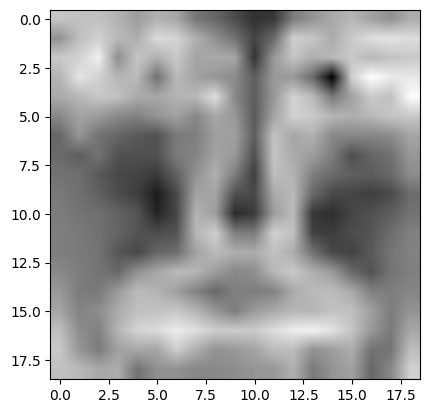

In [24]:
from matplotlib import pyplot as plt
# each column of corpus is a 19x19 image
plt.imshow(corpus[:,3].reshape(19,19).T, cmap='gray',interpolation='bilinear')

In [ ]:
W,H = nmf(corpus, 50,lr=0.01, epochs=10000, reg_lambda=0.01)